# Neural-based channel decoders


In [9]:
# -*- coding: utf-8 -*-
import matplotlib.pyplot as plt
import numpy as np
import keras 
import time

from keras.models import Sequential
from keras.utils import plot_model
from keras.layers import Dense, Dropout, Activation, GaussianNoise
from keras.optimizers import SGD

from src.communications import Transmitter, AWGNChannel, Receiver, ReceiverMode
from src.utils import ber_performance, get_basic_channel_fct, show_ber

# Configuration
MODULATION = 'BPSK'
G = np.array([[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
              [1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
              [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
              [1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0],
              [1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0],
              [1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0],
              [1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0],
              [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

# Initialization
transmitter = Transmitter(MODULATION, G)
channel = AWGNChannel(MODULATION, G)
receiver = Receiver(MODULATION, G, ReceiverMode.MAP)

if __name__ == '__main__':
    t = time.time()
    # receiver.block_elements contains all possible u^k (labels)
    # receiver.block_coded_elements contains all possible codewords c^n
    
    k = np.size(G, 0)
    n = np.size(G, 1)
    
    # Create model
    # We are working with probability, to have sum(s_i) = 1 at the output, we use a softmax instead of a sigmoid activation function
    # Because we are using a hit representation, we use a 
    encoder_model=Sequential()
    encoder_model.add(Dense(20*2**k, activation='relu', input_dim=k))
    encoder_model.add(Dense(2**k, activation='softmax'))
    
    encoder_model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    print(encoder_model.summary())
    
    # Create labels for hot representation
    labels = []
    for i in range(2**k):
        labels.append(np.zeros(2**k))
        labels[-1][i] = 1
    
    encoder_history = encoder_model.fit(
        np.array(receiver.block_elements), 
        np.array(labels), 
        epochs=10**4,
        verbose=0
    )
    encoder_model.save('networks/encoder.h5')
    
    print(f'Elapsed : {np.round(time.time() - t, 2)} s')


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 5120)              46080     
_________________________________________________________________
dense_12 (Dense)             (None, 256)               1310976   
Total params: 1,357,056
Trainable params: 1,357,056
Non-trainable params: 0
_________________________________________________________________
None
Elapsed : 317.25 s


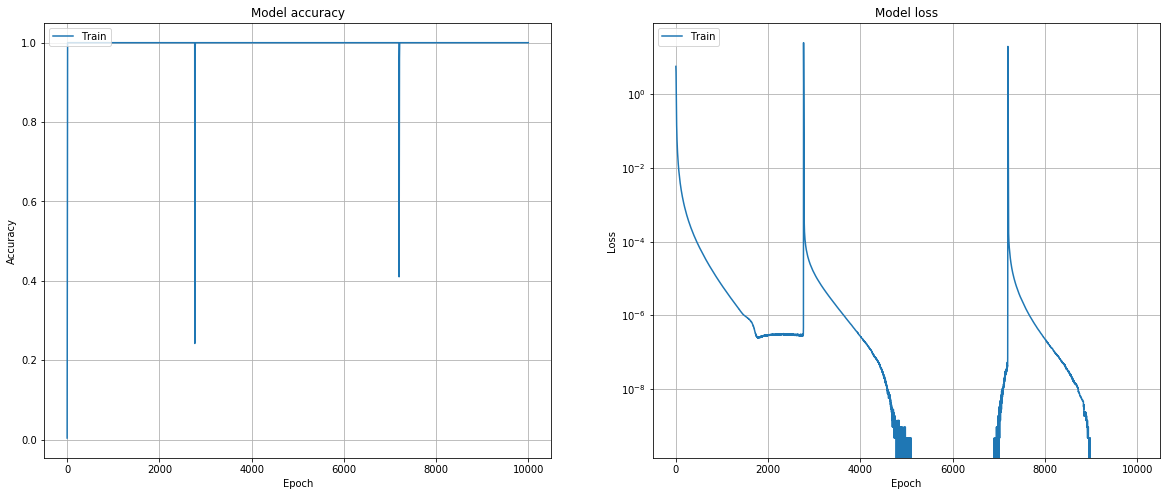

In [11]:
# Plot training & validation accuracy values
fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(121)
plt.grid()
plt.plot(encoder_history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')

# Plot training & validation loss values
ax = fig.add_subplot(122)
plt.grid()
plt.plot(encoder_history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.yscale('log')
# plt.subplots_adjust(wspace = 0.5)

[ 1.  1. -1. ... -1.  1.  1.]


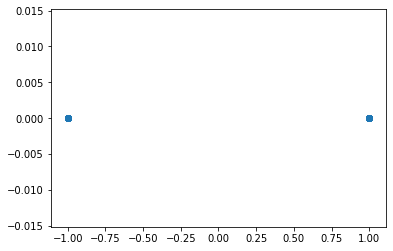

In [21]:
if __name__ == '__main__':
    k = np.size(G, 0)
    n = np.size(G, 1)
    N_n = 100
    b = np.random.randint(0, 2, k * N_n)

    # Create blocks
    c_r = encoder_model.predict(np.array(np.split(b, N_n)))
    c_r = np.array(list(map(lambda x: receiver.block_coded_elements[np.argmax(x)], c_r)))
    c_r = c_r.flatten()
    
    plt.figure()
    plt.scatter(c_r, c_r * 0)
    plt.show()
    